In [ ]:
# Function to create sequences
def create_sequences(data, labels, sequence_length=100):
    sequence_data = []
    sequence_labels = []
    for i in range(len(data) - sequence_length):
        sequence_data.append(data[i:i+sequence_length])
        sequence_labels.append(labels[i+sequence_length-1])
    return np.array(sequence_data), np.array(sequence_labels)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('/content/drive/MyDrive/7th sem Project/Final Real time Vibration.csv')

# Keeping only the columns related to Pump1 and Pump4
data = data[['Pump1 Vibration', 'Pump4 Vibration']]

# Melting the DataFrame and labeling the data
melted_data = data.melt(var_name='Label', value_name='Vibration')
melted_data['Label'] = melted_data['Label'].apply(lambda x: 'Healthy' if x == 'Pump1 Vibration' else 'Faulty')

# Normalizing and encoding labels
scaler = MinMaxScaler(feature_range=(0,1))
melted_data['Vibration'] = scaler.fit_transform(melted_data[['Vibration']])
label_encoder = LabelEncoder()
melted_data['Label'] = label_encoder.fit_transform(melted_data['Label'])
# Displaying basic information and the first few rows of the DataFrame
melted_data.info()
melted_data.head()
# Creating sequences and splitting data
seq_length = 100  # Using a smaller sequence length for faster training
X, y = create_sequences(melted_data['Vibration'],melted_data['Label'], seq_length)  # You need to define the create_sequences function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shapes of train and test data:")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205812 entries, 0 to 205811
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Label      205812 non-null  int64  
 1   Vibration  205812 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.1 MB
Shapes of train and test data:
(164569, 100, 1) (41143, 100, 1) (164569,) (41143,)


In [ ]:
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
import tensorflow as tf
input_shape = (100, 1)  # Adjusted for reduced sequence length
head_size = 128  # Reduced head size
num_heads = 2   # Reduced number of heads
ff_dim = 2      # Reduced feed-forward dimensions
num_transformer_blocks = 2  # Reduced transformer blocks for simplification
mlp_units = [64]  # Reduced MLP units for simplification
dropout = 0.1
mlp_dropout = 0.1

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
# Increase batch size
batch_size = 256

# Use learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)  # Added gradient clipping
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train the model with increased batch size

In [ ]:
from tensorflow.keras import layers
# Simplified Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_split=0.2, shuffle=False)

Epoch 1/5
515/515 [==============================] - 757s 1s/step - loss: 0.5245 - accuracy: 0.8763 - val_loss: 0.2426 - val_accuracy: 0.9743
Epoch 2/5
515/515 [==============================] - 736s 1s/step - loss: 0.1291 - accuracy: 0.9818 - val_loss: 0.0599 - val_accuracy: 0.9939
Epoch 3/5
515/515 [==============================] - 735s 1s/step - loss: 0.0442 - accuracy: 0.9945 - val_loss: 0.0255 - val_accuracy: 0.9985
Epoch 4/5
515/515 [==============================] - 724s 1s/step - loss: 0.0238 - accuracy: 0.9970 - val_loss: 0.0161 - val_accuracy: 0.9986
Epoch 5/5
515/515 [==============================] - 710s 1s/step - loss: 0.0148 - accuracy: 0.9983 - val_loss: 0.0101 - val_accuracy: 0.9990


1286/1286 [==============================] - 79s 61ms/step
Accuracy: 0.9991
Precision: 0.9982
Recall: 1.0000
F1 Score: 0.9991
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00     20631
      Faulty       1.00      1.00      1.00     20512

    accuracy                           1.00     41143
   macro avg       1.00      1.00      1.00     41143
weighted avg       1.00      1.00      1.00     41143



Text(0.5, 1.0, 'Accuracy')

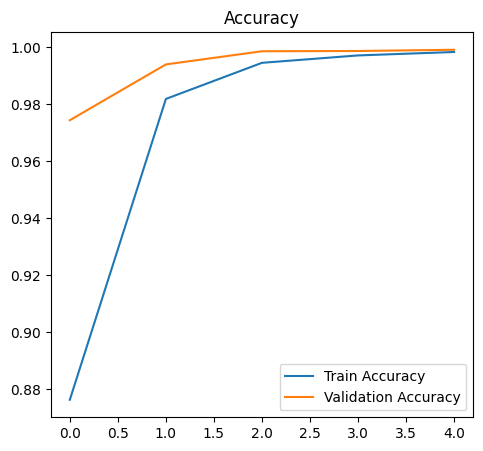

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Printing classification report for precision, recall, f1-score metrics
print(classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Faulty']))

# Visualization - Plotting loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


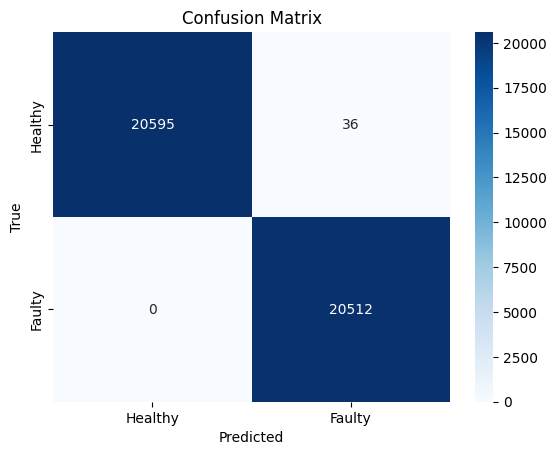

In [ ]:
cm = confusion_matrix(y_test,y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Printing classification report for precision, recall, f1-score metrics
print(classification_report(y_test, y_pred_binary, target_names=['Healthy', 'Faulty']))

# Visualization - Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

In [ ]:
cm = confusion_matrix(y_temp_test,y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Healthy', 'Faulty'], yticklabels=['Healthy', 'Faulty'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()